# Imports

In [1]:
import sys
import os


sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
print(sys.path[-1])

/home/cotsios/dsit/2nd-semester/ml-in-comp-bio/Assignment-1


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from scipy import stats

import umap

from src.visualization import (
    plot_kde,
    plot_feature_spans,
    plot_correlation_coefficients,
    plot_correlated_pairplot
)

# Paths

In [3]:
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
DATA_DIR = os.path.join(BASE_DIR, "data")
print(DATA_DIR)

/home/cotsios/dsit/2nd-semester/ml-in-comp-bio/Assignment-1/data


# The data

In [4]:
file_name = "assignment1_dev_set.csv"

df = pd.read_csv(os.path.join(DATA_DIR, file_name), index_col=0)
cols = df.columns

In [5]:
display(df.shape)
display(cols)

(489, 140)

Index(['Project ID', 'Experiment type', 'Sex', 'Host age', 'BMI',
       'Disease MESH ID', 'Acholeplasma axanthum',
       'Acidaminococcus fermentans', 'Acidaminococcus intestini',
       'Actinomyces lingnae',
       ...
       'Clostridium sphenoides', 'Clostridium spiroforme',
       'Clostridium stercorarium', 'Clostridium symbiosum',
       'Clostridium thermosuccinogenes', 'Clostridium xylanolyticum',
       'Eubacterium brachy', 'Eubacterium dolichum', 'Eubacterium sulci',
       'Ruminococcus gnavus'],
      dtype='object', length=140)

We can see that the `BMI` column is the 6<sup>th</sup> one and the bacterial concentrations start from the 8<sup>th</sup> column up to the last (141<sup>st</sup>)  
Also, since we want to classify `BMI` based **only** on the bacteria in the gut microbiome, we can **exclude** the following columns:
- `Project ID`
- `Experiment type`
- `Disease MESH ID`

Regarding the `Sex` and `Host age` columns, I decided to separate them in order to examine them one by one, and not with the bacterial data.

In [6]:
# drop columns Project ID, Experiment type, Sex, Host age, Disease MESH ID
cols_to_drop = [
    "Project ID",
    "Experiment type",
    "Sex",
    "Host age",
    "BMI",
    "Disease MESH ID"
]

bmi = df["BMI"]
sex = df["Sex"]
age = df["Host age"]
bacteria = df.drop(cols_to_drop, axis=1)

In [7]:
bacteria.head()

,Acholeplasma axanthum,Acidaminococcus fermentans,Acidaminococcus intestini,Actinomyces lingnae,Akkermansia muciniphila,Alistipes finegoldii,Alistipes indistinctus,Alistipes obesi,Alistipes onderdonkii,Alistipes putredinis,...,Clostridium sphenoides,Clostridium spiroforme,Clostridium stercorarium,Clostridium symbiosum,Clostridium thermosuccinogenes,Clostridium xylanolyticum,Eubacterium brachy,Eubacterium dolichum,Eubacterium sulci,Ruminococcus gnavus
0,0.000000,0.000000,0.000000,0.000000,0.017674,0.000000,0.00000,0.0,0.117827,0.005891,...,0.005891,0.029457,0.000000,0.000000,0.002946,0.000000,0.000000,0.000000,0.002946,0.100153
1,0.001028,0.000000,0.000000,0.000000,13.015800,0.001542,0.00000,0.0,0.073486,0.403916,...,0.000000,0.002569,0.412652,0.003083,0.000000,0.000000,0.008736,0.014903,0.077597,0.004625
2,0.001406,0.000000,0.000000,0.001406,0.002812,0.201074,0.00000,0.0,0.043590,0.105459,...,0.000000,0.005624,0.002812,0.007031,0.000000,0.000000,0.000000,0.000000,0.005624,0.016873
3,0.000000,0.008825,0.273562,0.000000,0.044123,0.004412,0.34857,0.0,0.026474,0.586834,...,0.017649,0.198553,0.000000,0.158842,0.030886,0.101483,0.000000,0.000000,0.000000,0.000000
4,0.002878,0.037419,7.359970,0.000000,0.872143,0.000000,0.00000,0.0,1.732770,1.004550,...,0.305106,0.135283,0.000000,0.051811,0.054689,0.083473,0.020148,0.000000,0.054689,0.011513


## General Statistics

### BMI

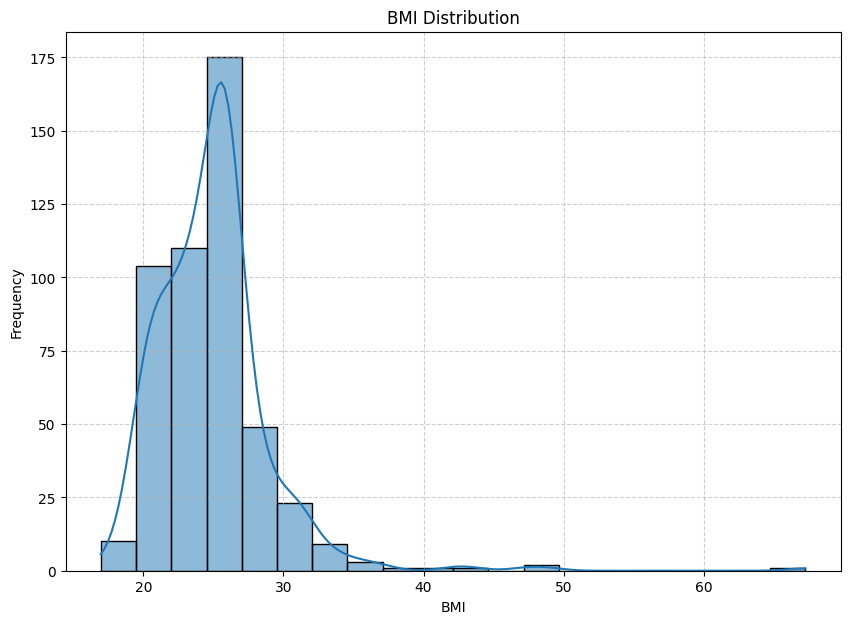

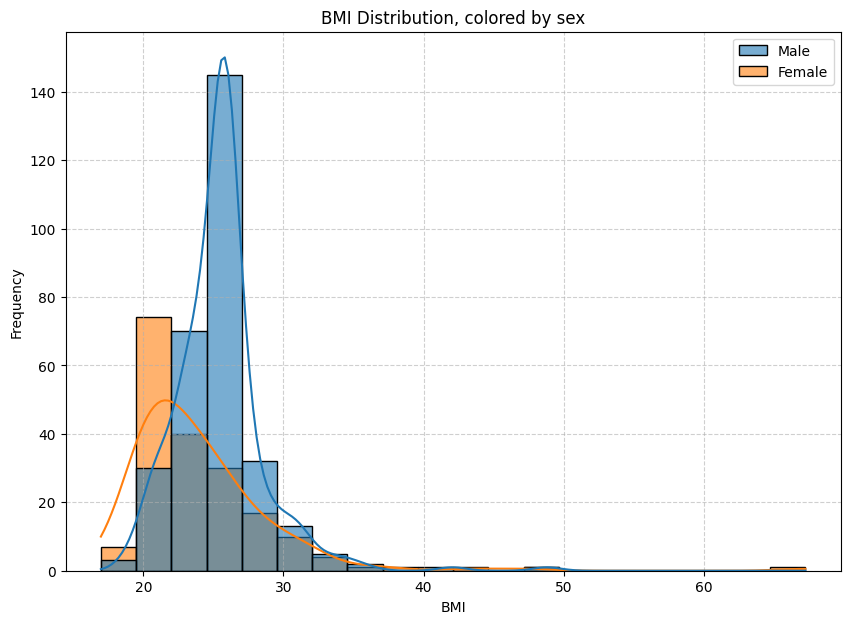

In [8]:
plot_kde(
    bmi,
    title="BMI Distribution",
    x_label="BMI"
)
plot_kde(
    bmi,
    title="BMI Distribution, colored by sex",
    x_label="BMI",
    hue_by=sex
)

In [9]:
# Perform the Lillefors (Kolmogorov-Smirnov) test for normality on BMI
alpha = 0.05
stat, p = stats.normaltest(bmi)
print(f"stat: {stat}, p: {p}")
if p < alpha:
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected, the data is normally distributed")

stat: 396.2275107282368, p: 9.126184747321433e-87
The null hypothesis can be rejected


### Bacteria

In [10]:
plot_feature_spans(bacteria)

Lets normalize them and see what they look like

In [11]:
zscaler = StandardScaler()
mmscaler = MinMaxScaler()

bacteria_zscaled = zscaler.fit_transform(bacteria)
bacteria_mmscaled = mmscaler.fit_transform(bacteria)

In [12]:
plot_feature_spans(bacteria_zscaled, title="Standardized Features")
plot_feature_spans(bacteria_mmscaled, title="MinMax Scaled Features")

### Sex and Age

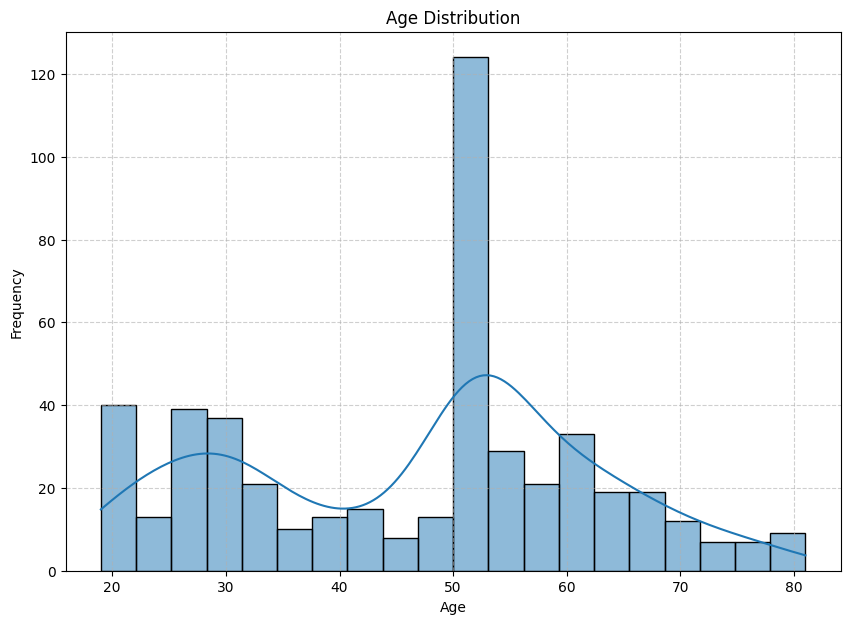

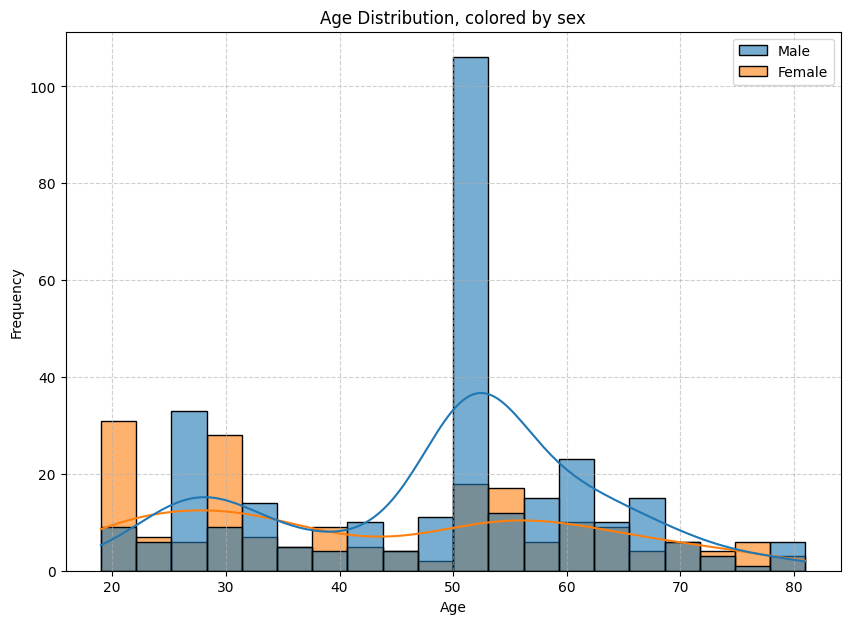

In [13]:
plot_kde(
    age,
    title="Age Distribution",
    x_label="Age"
)
plot_kde(
    age,
    title="Age Distribution, colored by sex",
    x_label="Age",
    hue_by=sex
)

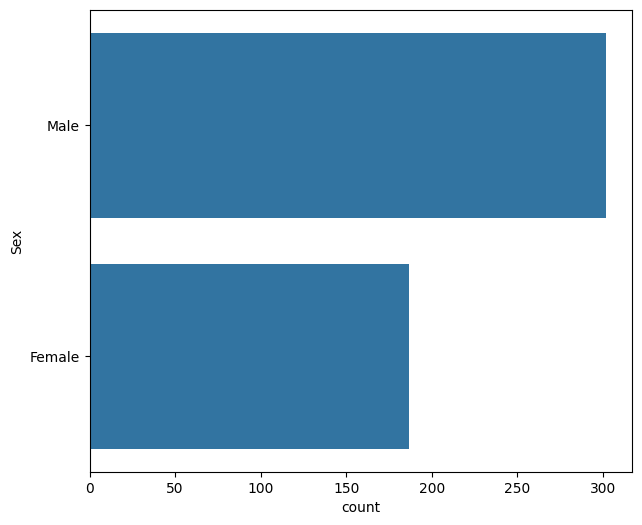

In [14]:
plt.figure(figsize=(7, 6))
sns.countplot(sex)
plt.show()

## Correlations

In [15]:
bacteria_corr_array_bmi, bactera_sorted_by_corr_bmi = plot_correlation_coefficients(
    bacteria,
    bmi,
    abs_corr=True,
    title="Correlation Coefficients (absolute values) of Bacteria against BMI"
)

In [16]:
bacteria_corr_array_age, bactera_sorted_by_corr_age = plot_correlation_coefficients(
    bacteria,
    age,
    title="Correlation Coefficients of Bacteria against age"
)

#### Correlation between features

Let's inspect the feature correlation of the top `n` most correlated bacteria with bmi.

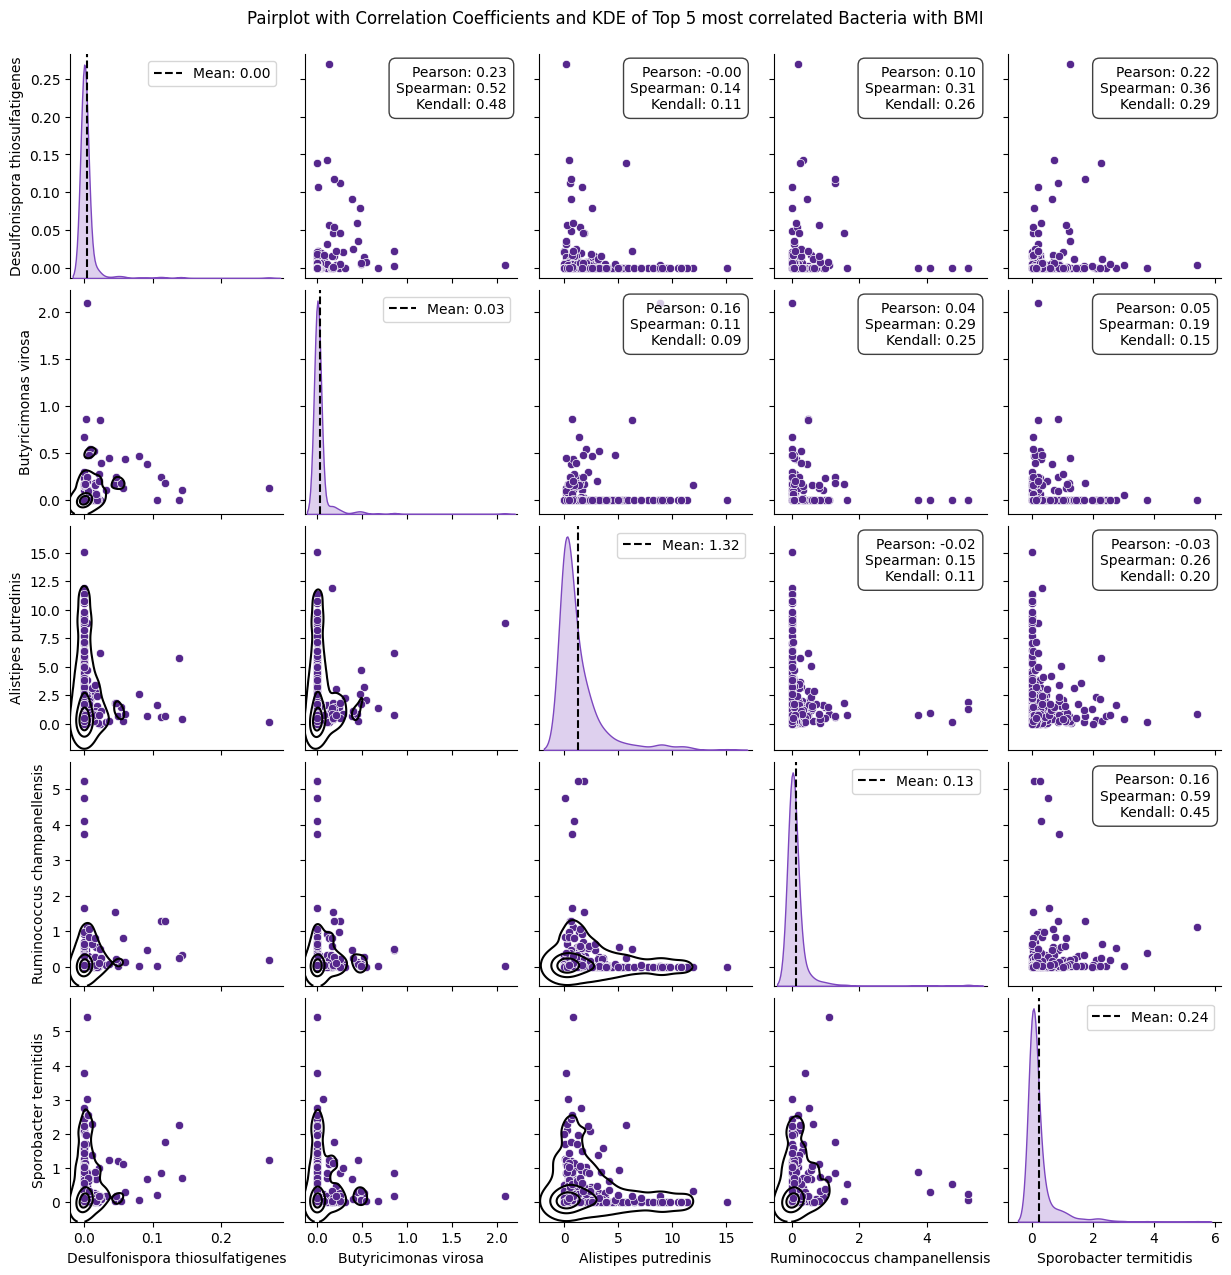

In [17]:
n = 5
first_n_bacteria_names = bactera_sorted_by_corr_bmi[:n]
first_n_bacteria = bacteria[first_n_bacteria_names]
plot_correlated_pairplot(
        first_n_bacteria,
        title="Pairplot with Correlation Coefficients and KDE of Top 5 most correlated Bacteria with BMI"
)

Same as above but for bacteria and age.

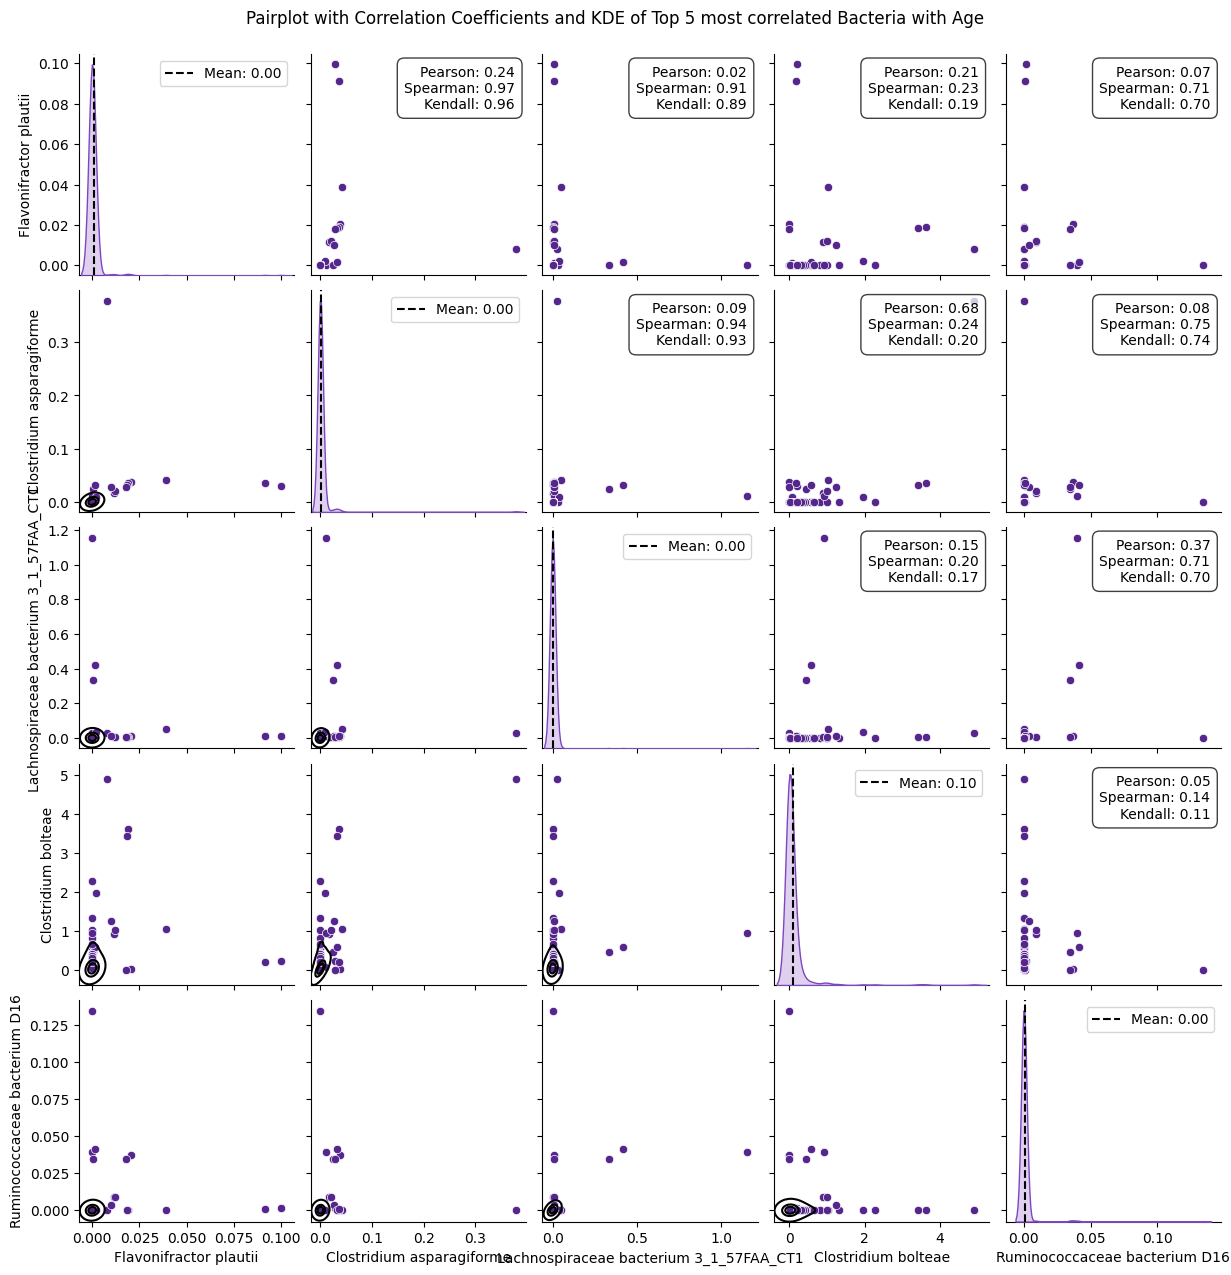

In [18]:
n = 5
first_n_bacteria_names = bactera_sorted_by_corr_age[:n]
first_n_bacteria = bacteria[first_n_bacteria_names]
plot_correlated_pairplot(
        first_n_bacteria,
        title="Pairplot with Correlation Coefficients and KDE of Top 5 most correlated Bacteria with Age"
)

## Visualizations on reduced dimensions on the feature space

Now lets inspect the feature space in reduced dimensions and see if we can find anything that might help us later on.

Number of components that explain 65% of the variance: 5


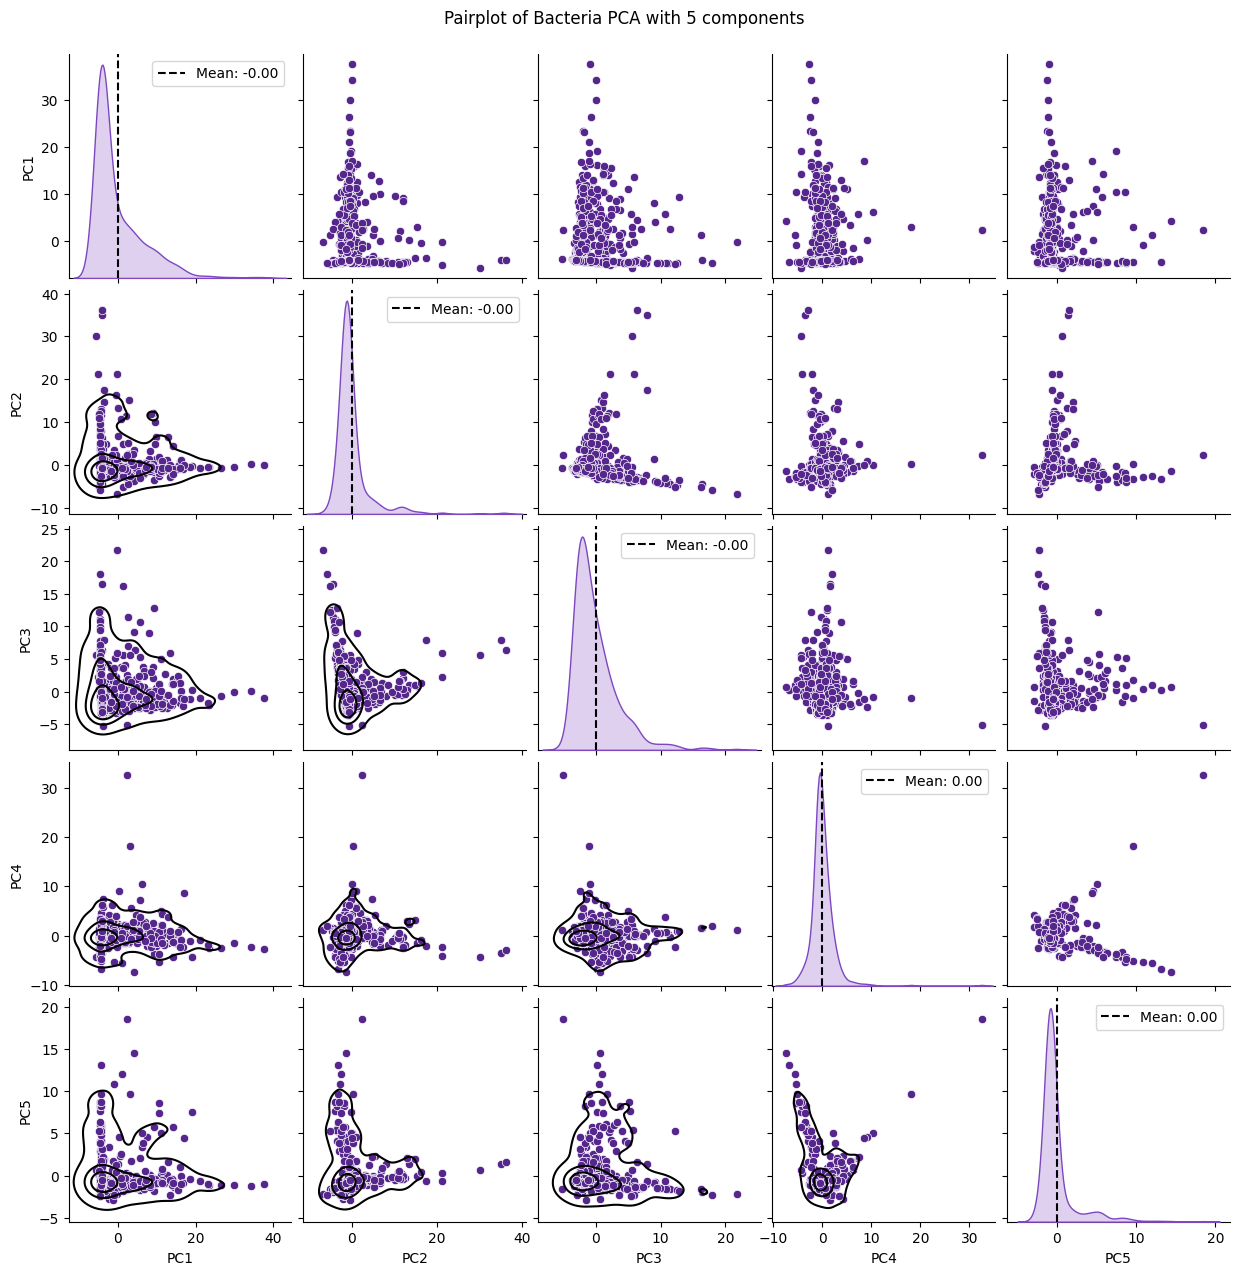

In [ ]:
# PCA
pca = PCA()
bacteria_pca = pca.fit_transform(bacteria)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)

n_components = np.argmax(cumulative_explained_variance_ratio > 0.65) + 1
print(f"Number of components that explain 65% of the variance: {n_components}")

plot_correlated_pairplot(
    pd.DataFrame(
        bacteria_pca[:, :n_components],
        columns=[f"PC{i}" for i in range(1, n_components + 1)]
    ),
    title=f"Pairplot of Bacteria PCA with {n_components} components",
    overlay_correlations=False
)

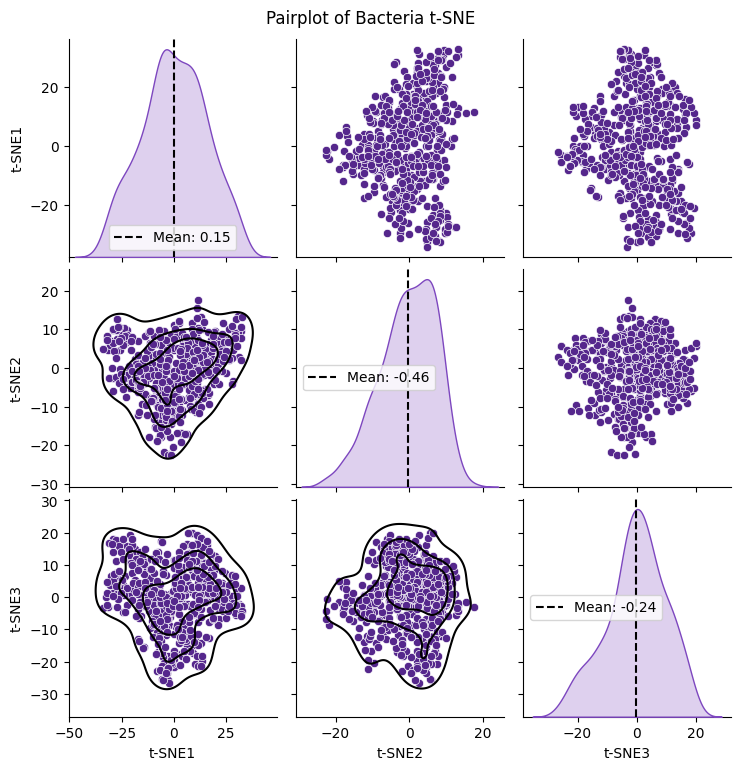

In [20]:
# t-SNE
tsne = TSNE(n_components=3)
bacteria_tsne = tsne.fit_transform(bacteria)

plot_correlated_pairplot(
    pd.DataFrame(
        bacteria_tsne,
        columns=[f"t-SNE{i}" for i in range(1, 4)]
    ),
    title="Pairplot of Bacteria t-SNE",
    overlay_correlations=False
)

/home/cotsios/dsit/2nd-semester/ml-in-comp-bio/Assignment-1/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



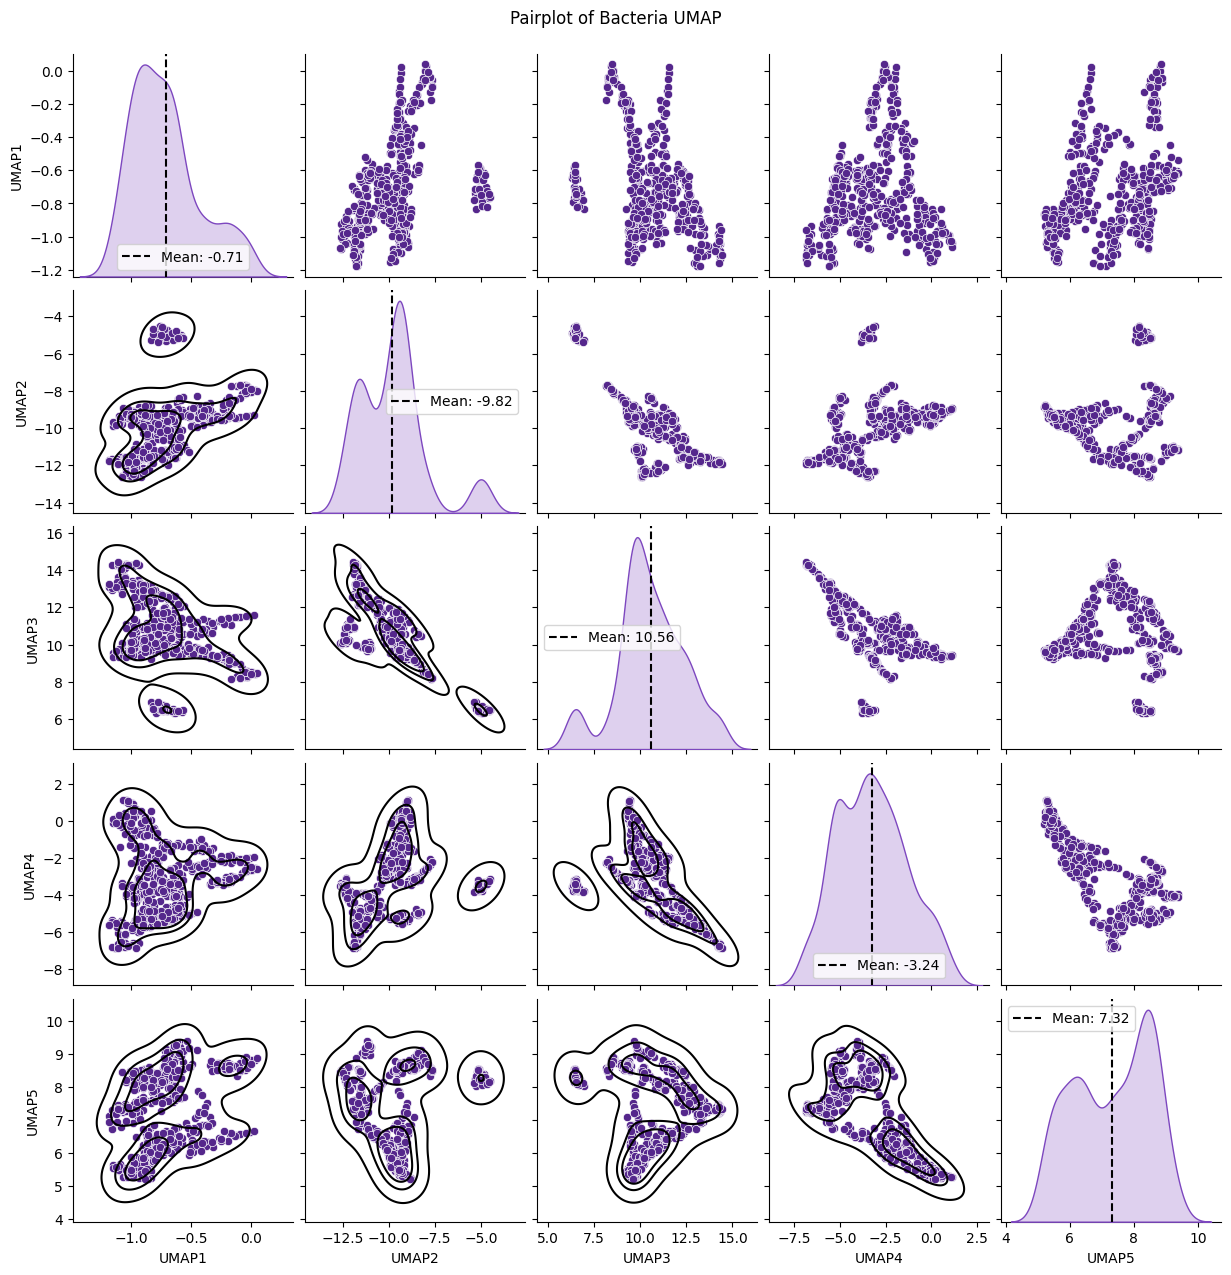

In [21]:
# UMAP
umap_model = umap.UMAP(n_components=5)
bacteria_umap = umap_model.fit_transform(bacteria)

plot_correlated_pairplot(
    pd.DataFrame(
        bacteria_umap,
        columns=[f"UMAP{i}" for i in range(1, 6)]
    ),
    title="Pairplot of Bacteria UMAP",
    overlay_correlations=False
)